In [1]:
import pandas as pd
from src.parameters import PROCESSED_DATA_DIR
import os

animal, day, epoch = "Jaq", 3, 16

position_info = pd.read_csv(
    os.path.join(PROCESSED_DATA_DIR, f"{animal}_{day}_{epoch}_position_info.csv")
)


Text(0, 0.5, 'y-position [cm]')

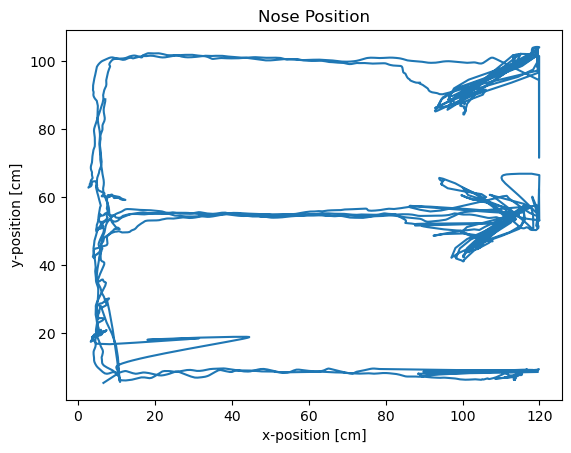

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(position_info.nose_x, position_info.nose_y)
ax.set_title("Nose Position")
ax.set_xlabel("x-position [cm]")
ax.set_ylabel("y-position [cm]")


(0.0, 100.0)

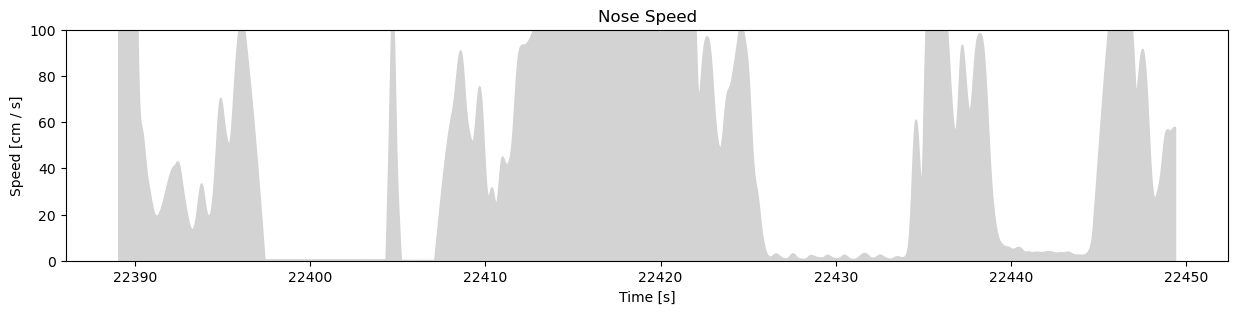

In [3]:
import numpy as np

fig, ax = plt.subplots(figsize=(15, 3))
ax.fill_between(
    position_info.time / np.timedelta64(1, "s"),
    position_info.nose_vel,
    color="lightgrey",
)
ax.set_title("Nose Speed")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Speed [cm / s]")
ax.set_ylim((0, 100))


Text(0, 0.5, 'Linear Position [cm]')

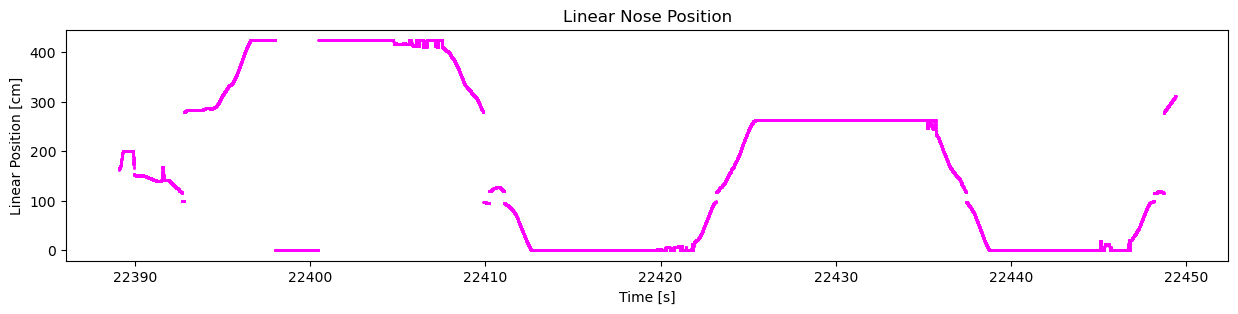

In [4]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.scatter(
    position_info.time / np.timedelta64(1, "s"),
    position_info.linear_position,
    s=1,
    color="magenta",
)
ax.set_title("Linear Nose Position")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Linear Position [cm]")


Text(0, 0.5, 'y-position [cm]')

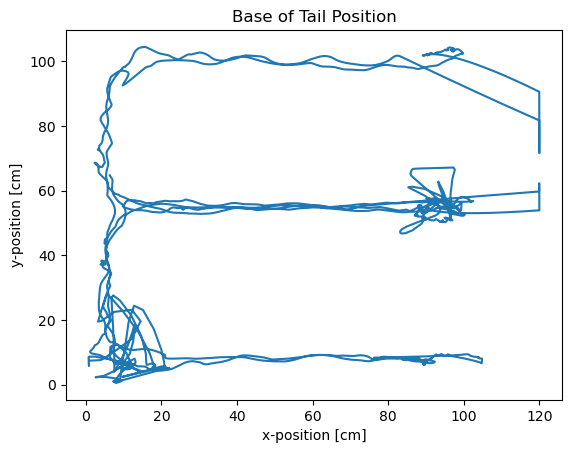

In [5]:
fig, ax = plt.subplots()
ax.plot(position_info.tailBase_x, position_info.tailBase_y)
ax.set_title("Base of Tail Position")
ax.set_xlabel("x-position [cm]")
ax.set_ylabel("y-position [cm]")


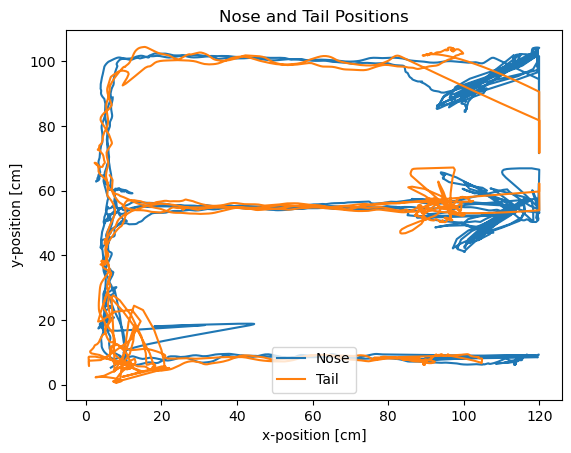

In [6]:
fig, ax = plt.subplots()
ax.plot(position_info.nose_x, position_info.nose_y, label="Nose")
ax.plot(position_info.tailBase_x, position_info.tailBase_y, label="Tail")
ax.set_title("Nose and Tail Positions")
ax.set_xlabel("x-position [cm]")
ax.set_ylabel("y-position [cm]")
ax.legend()


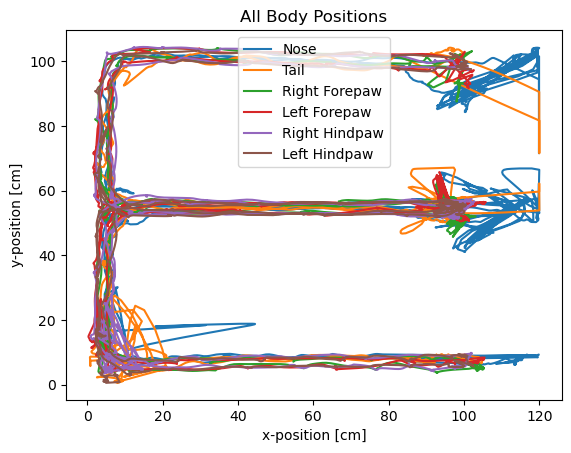

In [7]:
fig, ax = plt.subplots()
ax.plot(position_info.nose_x, position_info.nose_y, label="Nose")
ax.plot(position_info.tailBase_x, position_info.tailBase_y, label="Tail")
ax.plot(position_info.forepawR_x, position_info.forepawR_y, label="Right Forepaw")
ax.plot(position_info.forepawL_x, position_info.forepawL_y, label="Left Forepaw")
ax.plot(position_info.hindpawR_x, position_info.hindpawR_y, label="Right Hindpaw")
ax.plot(position_info.hindpawL_x, position_info.hindpawL_y, label="Left Hindpaw")
ax.set_title("All Body Positions")
ax.set_xlabel("x-position [cm]")
ax.set_ylabel("y-position [cm]")
ax.legend()


In [8]:
import xarray as xr
from replay_trajectory_classification import ClusterlessClassifier

results = xr.open_dataset(
    os.path.join(PROCESSED_DATA_DIR, f"{animal}_{day}_{epoch}_decoding_results.nc")
)

classifier = ClusterlessClassifier.load_model(
    os.path.join(
        PROCESSED_DATA_DIR, f"{animal}_{day}_{epoch}_cv_classifier_clusterless_nose.pkl"
    )
)


In [9]:
import copy
import seaborn as sns


def plot_decoding(
    time_slice,
    classifier,
    results,
    position_info,
    posterior_type="acausal_posterior",
    figsize=(10, 5),
    legend=True,
):
    t = position_info.time / np.timedelta64(1, "s")
    cmap = copy.copy(plt.get_cmap("bone_r"))
    cmap.set_bad(color="lightgrey", alpha=1.0)

    _, axes = plt.subplots(
        2,
        1,
        figsize=figsize,
        sharex=True,
        constrained_layout=True,
        gridspec_kw={"height_ratios": [3, 0.25]},
    )

    # ax 0
    (
        results[posterior_type]
        .sum("state")
        .where(classifier.is_track_interior_)
        .isel(time=time_slice)
        .plot(
            x="time",
            y="position",
            robust=True,
            ax=axes[0],
            cmap=cmap,
            vmin=0.0,
            add_colorbar=legend,
        )
    )

    axes[0].set_ylabel("Position [cm]")

    axes[0].scatter(
        position_info.reset_index().set_index(t).iloc[time_slice].index,
        position_info.reset_index().set_index(t).iloc[time_slice].linear_position,
        color="magenta",
        alpha=0.8,
        s=10,
        zorder=100,
        clip_on=False,
    )
    axes[0].set_xlabel("")

    # ax 1
    axes[1].fill_between(
        position_info.reset_index().set_index(t).iloc[time_slice].index,
        np.abs(
            position_info.reset_index()
            .set_index(t)
            .iloc[time_slice]
            .tailBase_vel.values.squeeze()
        ),
        color="lightgrey",
        linewidth=1,
        alpha=0.5,
    )
    axes[1].set_ylabel("Speed \n[cm / s]")

    axes[-1].set_xlabel("Time [s]")
    axes[-1].ticklabel_format(style="plain", axis="x")

    sns.despine()


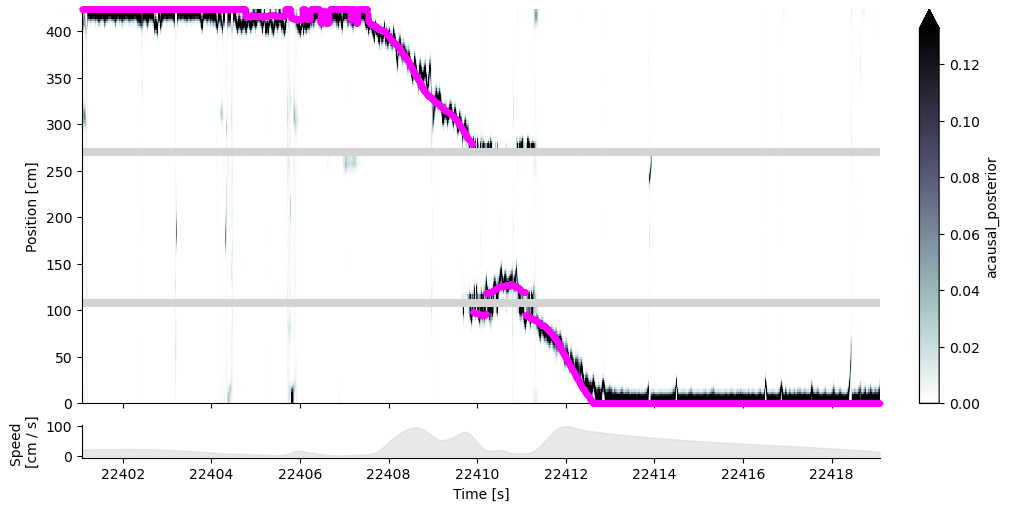

In [10]:
time_slice = slice(6000, 15_000)

plot_decoding(
    time_slice,
    classifier,
    results,
    position_info,
)
